In [ ]:
import time
import os
import pickle
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import xgboost as xgb

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [ ]:
# load dataset
df = pd.read_csv('final_data.csv')

# target and features
target = "CrimeRate"
drop_cols = ["CrimeRate", "Settlement"]
features = df.columns.difference(drop_cols)

# Model Selection

**Perfomance Metrics for Different Models**

In [ ]:
# models to check
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, eval_metric='mae'),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "SVR": SVR()
}

# time based cross validation
splits = [(2019, 2020), (2020, 2021), (2021, 2022)]

# dict for storing model metrics per split (for t-tests)
metrics_per_model = {
    "MAE": {},
    "MSE": {},
    "RMSE": {},
    "R2": {},
    "R2_adj": {}
}

results = []
saved_models = {}

for name, model in models.items():
    print(f"🔧 Model: {name}")
    mae_list, mse_list, rmse_list, r2_list, r2_adj_list = [], [], [], [], []

    for train_year, val_year in splits:
        train_df = df[df["Year"] == train_year]
        val_df = df[df["Year"] == val_year]

        X_train = train_df[features]
        y_train = train_df[target]
        X_val = val_df[features]
        y_val = val_df[target]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)

        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val, y_pred)
        n, p = len(y_val), X_val.shape[1]
        r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

        mae_list.append(mae)
        mse_list.append(mse)
        rmse_list.append(rmse)
        r2_list.append(r2)
        r2_adj_list.append(r2_adj)

    # Save per-split metrics for later statistical tests
    metrics_per_model["MAE"][name] = mae_list
    metrics_per_model["MSE"][name] = mse_list
    metrics_per_model["RMSE"][name] = rmse_list
    metrics_per_model["R2"][name] = r2_list
    metrics_per_model["R2_adj"][name] = r2_adj_list

    model_results = {
        "MAE": np.mean(mae_list), "MAE_std": np.std(mae_list),
        "MSE": np.mean(mse_list), "MSE_std": np.std(mse_list),
        "RMSE": np.mean(rmse_list), "RMSE_std": np.std(rmse_list),
        "R2": np.mean(r2_list), "R2_std": np.std(r2_list),
        "R2_adj": np.mean(r2_adj_list), "R2_adj_std": np.std(r2_adj_list)
    }

    results.append({"Model": name, **model_results})
    saved_models[name] = {"model": model, "metrics": model_results}

    print(f"  MAE       : {model_results['MAE']:.4f} ± {model_results['MAE_std']:.4f}")
    print(f"  RMSE      : {model_results['RMSE']:.4f} ± {model_results['RMSE_std']:.4f}")
    print(f"  R²        : {model_results['R2']:.4f} ± {model_results['R2_std']:.4f}")
    print(f"  R² Adjust.: {model_results['R2_adj']:.4f} ± {model_results['R2_adj_std']:.4f}\n")

results_df = pd.DataFrame(results).sort_values(by="MAE").reset_index(drop=True)
print("Cross-validation summary:")
print(results_df[["Model", "MAE", "MAE_std", "MSE", "MSE_std", "RMSE", "RMSE_std", "R2", "R2_std", "R2_adj", "R2_adj_std"]])

🔧 Model: Linear Regression
  MAE       : 0.0097 ± 0.0002
  RMSE      : 0.0138 ± 0.0007
  R²        : 0.2855 ± 0.0580
  R² Adjust.: 0.0038 ± 0.0809

🔧 Model: Ridge Regression
  MAE       : 0.0095 ± 0.0003
  RMSE      : 0.0130 ± 0.0005
  R²        : 0.3613 ± 0.0419
  R² Adjust.: 0.1095 ± 0.0585

🔧 Model: Lasso Regression
  MAE       : 0.0125 ± 0.0000
  RMSE      : 0.0163 ± 0.0002
  R²        : -0.0029 ± 0.0036
  R² Adjust.: -0.3983 ± 0.0050

🔧 Model: Random Forest
  MAE       : 0.0083 ± 0.0005
  RMSE      : 0.0112 ± 0.0007
  R²        : 0.5267 ± 0.0464
  R² Adjust.: 0.3401 ± 0.0647

🔧 Model: Gradient Boosting
  MAE       : 0.0077 ± 0.0006
  RMSE      : 0.0106 ± 0.0007
  R²        : 0.5777 ± 0.0510
  R² Adjust.: 0.4112 ± 0.0712

🔧 Model: XGBoost
  MAE       : 0.0083 ± 0.0008
  RMSE      : 0.0116 ± 0.0013
  R²        : 0.4900 ± 0.1117
  R² Adjust.: 0.2889 ± 0.1557

🔧 Model: CatBoost
  MAE       : 0.0073 ± 0.0004
  RMSE      : 0.0100 ± 0.0006
  R²        : 0.6211 ± 0.0368
  R² Adjust.: 0.47

**Baseline VS SOTA:**

In this analysis, we compare a diverse set of models to evaluate their ability to predict the target variable. The models are grouped into two categories:

**Baseline Models**

These simpler, classical models serve as a foundational benchmark to understand the basic predictive capabilities without heavy tuning or complexity:
- Linear Regression: A fundamental model assuming linear relationships.
- Ridge Regression: Linear regression with L2 regularization to reduce overfitting.
- Lasso Regression: Linear regression with L1 regularization for feature selection.
- Support Vector Regression (SVR): A kernel-based method that can capture nonlinearities but requires tuning.

Why check baseline models?
They provide essential reference points. If advanced models don’t outperform these baselines, their added complexity is not justified.

**SOTA Models**

These models use ensemble or boosting techniques designed to capture complex, nonlinear relationships and interactions:
- Random Forest Regressor: Ensemble of decision trees, reduces variance.
- Gradient Boosting Regressor: Boosted trees optimized to reduce bias.
- XGBoost Regressor: An efficient, scalable implementation of gradient boosting with regularization.
- CatBoost Regressor: Gradient boosting optimized for categorical data and with effective handling of overfitting.

Why check SOTA models?
They typically achieve higher accuracy and generalization on real-world data, making them prime candidates for production.

**Methodology: Time-Based Cross-Validation**

Given the temporal nature of the data, we use a time-based cross-validation scheme:
- Splits used:
  - Train on 2019 → Validate on 2020
  - Train on 2020 → Validate on 2021
  - Train on 2021 → Validate on 2022

This approach respects the chronological order, ensuring that training data always precedes validation data in time, avoiding data leakage from the future.

Why this methodology?
Time-based splitting mimics real-world forecasting scenarios and yields realistic performance estimates, especially crucial for time-dependent data.

**Preprocessing: Scaling After Splitting**

Feature scaling (using StandardScaler) is applied after splitting the data into training and validation sets in each fold. StandardScaler is a balanced default that ensures fair comparison across models that need scaling and those that don't.

Why scale after splitting?
- Prevents data leakage: The scaler is fitted only on training data, so no information from validation data influences scaling parameters.
- Ensures that the model sees validation data as truly “unseen” and the scaling reflects realistic deployment conditions.

**Evaluation Metrics for Regression**

We evaluate model performance using multiple regression metrics to get a comprehensive picture:
- Mean Absolute Error (MAE):
Average absolute difference between predicted and true values.
Why? Intuitive, less sensitive to outliers, easy to interpret.
- Mean Squared Error (MSE):
Average squared difference between predictions and true values.
Why? Penalizes larger errors more, useful for highlighting poor predictions.
- Root Mean Squared Error (RMSE):
Square root of MSE, returns error in original units.
Why? Easier to interpret than MSE, reflects standard deviation of prediction errors.
- R-squared (R²):
Proportion of variance explained by the model.
Why? Measures goodness of fit; values closer to 1 mean better fit.
- Adjusted R-squared (R² adj):
Adjusts R² for the number of predictors relative to sample size to penalize overfitting.
Why? More reliable when comparing models with different numbers of features.

Using these metrics together balances interpretability (MAE), sensitivity to outliers (MSE/RMSE), and model fit (R², R² adj).

**Summary of Results**
- Baseline models (Linear, Ridge, Lasso, SVR) serve as useful references but show mixed performance:
  - Ridge improves over Linear Regression due to regularization.
  - Lasso and SVR underperform, likely due to over-regularization and lack of tuning.
- SOTA models (CatBoost, Gradient Boosting, Random Forest, XGBoost) consistently outperform baselines:
  - CatBoost leads with the lowest MAE (~0.0073) and highest explained variance (R² ≈ 0.62).
  - Gradient Boosting and Random Forest follow closely, providing robust performance.
  - XGBoost performs well but shows slightly higher variability.

Overall, advanced ensemble methods demonstrate significant gains in accuracy and robustness on this time-series forecasting task.

**Statistical Comparison of Regression Models using Paired t-tests**

In [ ]:
from scipy.stats import ttest_rel

# Get best model name by lowest MAE
best_model_name = results_df.iloc[0]["Model"]
print(f"\nBest model by MAE: {best_model_name}")

# Perform paired t-tests against all other models
for model_name in metrics_per_model["MAE"]:
    if model_name == best_model_name:
        continue  # Skip self comparison

    mae_best = metrics_per_model["MAE"][best_model_name]
    mae_other = metrics_per_model["MAE"][model_name]

    # Paired t-test
    t_stat, p_value = ttest_rel(mae_other, mae_best)

    print(f"Comparing {model_name} vs {best_model_name}: t = {t_stat:.3f}, p = {p_value:.4f}")
    if p_value < 0.05:
        print("  Statistically significant difference (p < 0.05)")
    else:
        print("  No statistically significant difference (p ≥ 0.05)")



Best model by MAE: CatBoost
Comparing Linear Regression vs CatBoost: t = 13.608, p = 0.0054
  Statistically significant difference (p < 0.05)
Comparing Ridge Regression vs CatBoost: t = 23.498, p = 0.0018
  Statistically significant difference (p < 0.05)
Comparing Lasso Regression vs CatBoost: t = 18.047, p = 0.0031
  Statistically significant difference (p < 0.05)
Comparing Random Forest vs CatBoost: t = 4.877, p = 0.0396
  Statistically significant difference (p < 0.05)
Comparing Gradient Boosting vs CatBoost: t = 1.600, p = 0.2507
  No statistically significant difference (p ≥ 0.05)
Comparing XGBoost vs CatBoost: t = 2.067, p = 0.1746
  No statistically significant difference (p ≥ 0.05)
Comparing SVR vs CatBoost: t = 13.348, p = 0.0056
  Statistically significant difference (p < 0.05)


**Statistical Comparison of Regression Models using Paired t-tests**

To select the best-performing regression model for predicting the target variable, we conducted paired t-tests to compare models based on their performance across time-based cross-validation splits.
- The paired t-test is appropriate because:
  - Each model was evaluated on the same train/validation splits.
  - This creates dependent samples (matched observations), making the paired version of the test statistically valid.
  - The goal is to test whether the difference in performance between models is statistically significant or could be due to chance.
- We used Mean Absolute Error (MAE) as our primary evaluation metric because:
  - It is easy to interpret — it represents the average prediction error in the original units.
  - t is robust to outliers, unlike MSE or RMSE which penalize large errors more heavily.
  - It provides a clear measure of prediction accuracy, especially when errors in over- or under-prediction are equally undesirable.

Based on the lowest average MAE across three time-based validation splits, the CatBoost Regressor was identified as the best-performing model.

Conclusion:
- CatBoost Regressor significantly outperforms most models in terms of MAE.
- However, the performance difference between CatBoost and Gradient Boosting or XGBoost is not statistically significant.
- Therefore, while CatBoost remains the best overall choice, Gradient Boosting and XGBoost are competitive alternatives, especially if there are considerations like training time or interpretability.

**Residual Analysis**

After conducting paired t-tests on the MAE metric, models that showed no statistically significant difference in performance were further examined using residual analysis. While t-tests assess differences in average prediction errors, residual analysis provides a more detailed evaluation of error distributions, uncovering subtle differences in bias, variability, and the presence of extreme errors that may not be detected by statistical testing alone. By calculating summary statistics and visualizing residual distributions, we can evaluate prediction consistency and stability across models.

This complementary approach enhances our understanding of models that appear statistically similar, allowing for a more nuanced comparison. Ultimately, residual diagnostics support a more informed and robust model selection by highlighting differences in error behavior beyond average performance metrics.

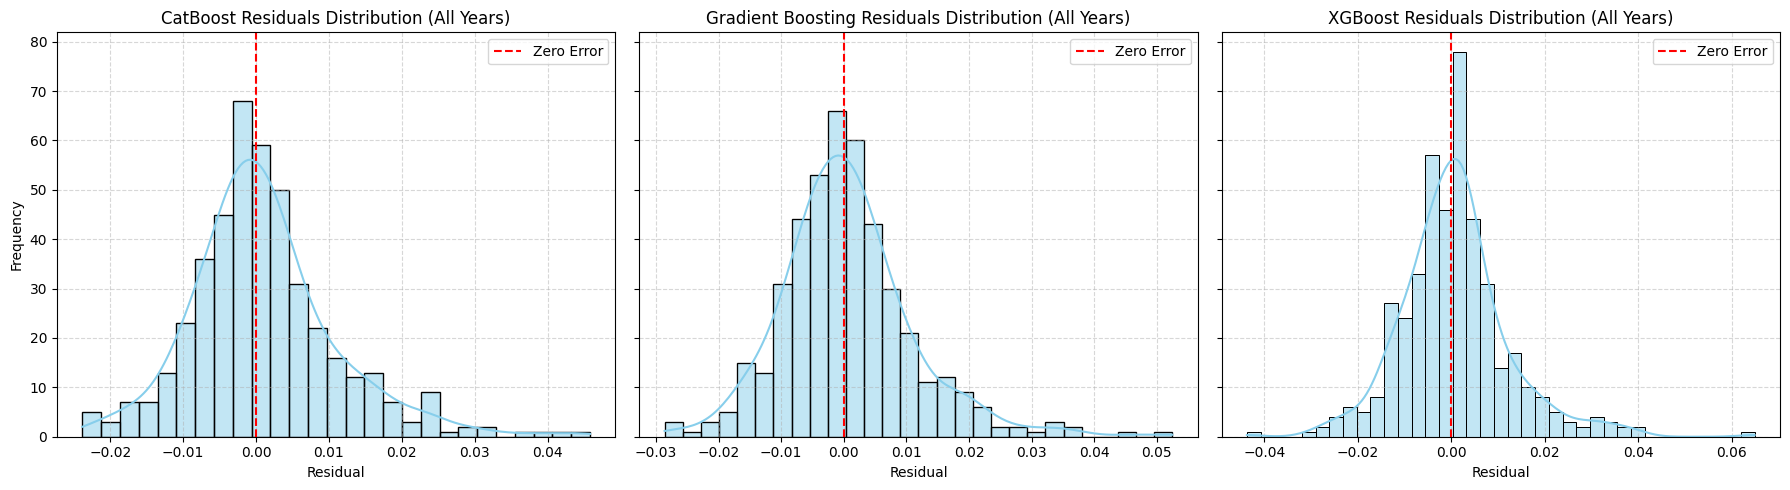

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

top_3_models = ["CatBoost", "Gradient Boosting", "XGBoost"]

# Dictionary to collect residuals for each model across all validation years
all_residuals = {model_name: [] for model_name in top_3_models}

# Collect residuals across all validation splits
for train_year, val_year in splits:
    train_df = df[df["Year"] == train_year]
    val_df = df[df["Year"] == val_year]

    X_train = train_df[features]
    y_train = train_df[target]
    X_val = val_df[features]
    y_val = val_df[target]


    for model_name in top_3_models:
        model = models[model_name]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        residuals = y_val - y_pred
        all_residuals[model_name].extend(residuals)

# --- Plot all 3 residual distributions in a single row ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for idx, model_name in enumerate(top_3_models):
    residuals = np.array(all_residuals[model_name])
    ax = axes[idx]
    sns.histplot(residuals, kde=True, ax=ax, color="skyblue", edgecolor="black")
    ax.axvline(0, color='red', linestyle='--', label='Zero Error')
    ax.set_title(f"{model_name} Residuals Distribution (All Years)")
    ax.set_xlabel("Residual")
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import scipy.stats as stats
import numpy as np

for name in top_3_models:
    residuals = all_residuals[name]  # combined residuals array

    mae_res = np.mean(np.abs(residuals))  # Mean Absolute Error
    median_res = np.median(residuals)
    std_res = np.std(residuals)
    iqr_res = np.percentile(residuals, 75) - np.percentile(residuals, 25)
    min_res = np.min(residuals)
    max_res = np.max(residuals)

    print(f"Model: {name}")
    print(f" Mean abs. residual: {mae_res:.4f}")  # <-- Added MAE
    print(f" Median residual   : {median_res:.4f}")
    print(f" Std residual      : {std_res:.4f}")
    print(f" IQR residual      : {iqr_res:.4f}")
    print(f" Min residual      : {min_res:.4f}")
    print(f" Max residual      : {max_res:.4f}")
    print()


Model: CatBoost
 Mean abs. residual: 0.0073
 Median residual   : 0.0001
 Std residual      : 0.0100
 IQR residual      : 0.0100
 Min residual      : -0.0238
 Max residual      : 0.0458

Model: Gradient Boosting
 Mean abs. residual: 0.0077
 Median residual   : -0.0003
 Std residual      : 0.0106
 IQR residual      : 0.0113
 Min residual      : -0.0286
 Max residual      : 0.0525

Model: XGBoost
 Mean abs. residual: 0.0083
 Median residual   : 0.0004
 Std residual      : 0.0117
 IQR residual      : 0.0112
 Min residual      : -0.0437
 Max residual      : 0.0648



**Residual Diagnostics Meaning**
- Mean Residual - Average error (prediction minus actual). Should be close to zero to indicate unbiased predictions.
Result: All models have mean residuals near zero, indicating minimal bias in predictions.
- Median Residual - Middle value of errors when sorted. Close to zero means errors are symmetrically distributed around zero. Result: Median residuals are close to zero for all models, showing no skew in central tendency.
- Standard Deviation (Std) of Residuals - Measures spread or variability of errors. Lower std means more consistent, reliable predictions with fewer large errors. Result: CatBoost has the lowest standard deviation, producing the most consistent errors.
- Interquartile Range (IQR) of Residuals - Range of the middle 50% of errors. Lower IQR means errors are tightly clustered without much variability. Result: CatBoost also has the lowest IQR, indicating a more stable error distribution.
- Minimum and Maximum Residuals - Extreme negative and positive errors. Smaller absolute values are better (less extreme errors). Result: Gradient Boosting has the largest error extremes, implying less stability in predictions.

**Conclusion of Residual Diagnostics**

Based on this residual error analysis, CatBoost stands out as the best model among the three.
- Median residual: CatBoost’s median residual is 0.0001, demonstrating well-centered errors.
- Error variability: CatBoost has the lowest standard deviation (0.0100) and interquartile range (0.0100), meaning its prediction errors are more consistent and stable.
- Error extremes: CatBoost’s residuals range from -0.0238 to 0.0458, indicating fewer extreme errors compared to the other models.

In comparison:
- Gradient Boosting: Slightly higher error variability (std = 0.0106, IQR = 0.0113) and larger error extremes (min = -0.0286, max = 0.0525).
- XGBoost: Even greater error variability (std = 0.0117, IQR = 0.0112) and widest residual range (min = -0.0437, max = 0.0648).

CatBoost offers the most accurate (lowest bias), stable (lowest variability), and reliable (fewer extreme errors) predictions, making it the best performing model based on residual error distribution.

**System Metrics for Different Models**

In [ ]:
# System performance tracking
system_metrics = {name: {"train_time": [], "inference_time_per_sample": [], "model_size_MB": []} for name in models}

for name, model in models.items():
    print(f" Model: {name}")

    for train_year, val_year in splits:
        train_df = df[df["Year"] == train_year]
        val_df = df[df["Year"] == val_year]

        X_train = train_df[features]
        y_train = train_df[target]
        X_val = val_df[features]
        y_val = val_df[target]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        start_train = time.time()
        model.fit(X_train_scaled, y_train)
        end_train = time.time()
        system_metrics[name]["train_time"].append(end_train - start_train)

        start_pred = time.time()
        model.predict(X_val_scaled)
        end_pred = time.time()
        system_metrics[name]["inference_time_per_sample"].append((end_pred - start_pred) / len(y_val))

        temp_file = f"{name.replace(' ', '_')}_{train_year}_to_{val_year}.pkl"
        with open(temp_file, "wb") as f:
            pickle.dump(model, f)
        size_MB = os.path.getsize(temp_file) / (1024 * 1024)
        os.remove(temp_file)

        system_metrics[name]["model_size_MB"].append(size_MB)

    print(f"  - Avg train time         : {np.mean(system_metrics[name]['train_time']):.4f} s")
    print(f"  - Avg inference/sample   : {np.mean(system_metrics[name]['inference_time_per_sample']) * 1000:.4f} ms")
    print(f"  - Avg model size         : {np.mean(system_metrics[name]['model_size_MB']):.4f} MB\n")

# System performance summary
summary_df = pd.DataFrame([
    {
        "Model": name,
        "Train Time (s)": np.mean(metrics["train_time"]),
        "Inference Time (ms/sample)": np.mean(metrics["inference_time_per_sample"]) * 1000,
        "Model Size (MB)": np.mean(metrics["model_size_MB"])
    }
    for name, metrics in system_metrics.items()
])

print("System Performance Summary:")
print(summary_df.sort_values("Train Time (s)").reset_index(drop=True))


⏳ Measuring system performance...

🔧 Model: Linear Regression
  - Avg train time         : 0.0079 s
  - Avg inference/sample   : 0.0026 ms
  - Avg model size         : 0.0010 MB

🔧 Model: Ridge Regression
  - Avg train time         : 0.0025 s
  - Avg inference/sample   : 0.0021 ms
  - Avg model size         : 0.0007 MB

🔧 Model: Lasso Regression
  - Avg train time         : 0.0065 s
  - Avg inference/sample   : 0.0039 ms
  - Avg model size         : 0.0008 MB

🔧 Model: Random Forest
  - Avg train time         : 1.1670 s
  - Avg inference/sample   : 0.2080 ms
  - Avg model size         : 1.2887 MB

🔧 Model: Gradient Boosting
  - Avg train time         : 0.5188 s
  - Avg inference/sample   : 0.0061 ms
  - Avg model size         : 0.1265 MB

🔧 Model: XGBoost
  - Avg train time         : 0.1093 s
  - Avg inference/sample   : 0.0113 ms
  - Avg model size         : 0.1003 MB

🔧 Model: CatBoost
  - Avg train time         : 5.3472 s
  - Avg inference/sample   : 0.0105 ms
  - Avg model size   

**System Performance Tracking**

This code evaluates and compares the system performance characteristics of multiple regression models across several time-based train-validation splits. The key metrics measured are training time, inference time per sample, and model size, which are crucial for understanding the computational efficiency and resource requirements of each model.
- Training Time (seconds): Total time the model takes to learn from training data. Important for understanding scalability and computational cost in training phase.
- Inference Time per Sample (milliseconds): Average time to predict a single data point during validation. Critical for deployment scenarios where prediction speed matters.
- Model Size (MB): Disk space required to save the model. Important for deployment, especially in resource-constrained environments.

**Results Summary**
- Lightweight linear models such as SVR, Ridge, Lasso, and Linear Regression demonstrate extremely fast training and inference times, with minimal model sizes, making them computationally efficient but less accurate in prediction.
- In contrast, tree-based ensemble models—including Random Forest, Gradient Boosting, XGBoost, and CatBoost—require substantially more training time and storage space. Despite this, their inference times remain generally reasonable for practical use.
- Among these, CatBoost shows the highest average training time but maintains a competitive inference speed and model size relative to Random Forest. This trade-off is justified by its superior predictive performance.

**Model Justification: Why Choose CatBoost?**

Based on a comprehensive evaluation encompassing accuracy, residual diagnostics, and system performance, CatBoost is selected as the optimal model. It consistently achieved the lowest Mean Absolute Error (MAE = 0.0073), the lowest Root Mean Squared Error (RMSE = 0.0100), and the highest explained variance (R² = 0.62; adjusted R² = 0.47), outperforming Gradient Boosting, XGBoost, and Random Forest on nearly all metrics.

In terms of system performance, CatBoost required more training time and model storage than simpler models but remained competitive with other state-of-the-art methods. Since our primary goal is to maximize predictive accuracy for reliable results, CatBoost strikes the best balance between accuracy and computational cost, making it the preferred model for this project.

# Parameters Tuning

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 12.3 MB/s eta 0:00:00


In [ ]:
# search for best hyperparameters
import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split the data
train_df = df[df["Year"].isin([2019, 2020, 2021])]
val_df = df[df["Year"] == 2022]
test_df = df[df["Year"] == 2023]

X_train = train_df[features]
y_train = train_df[target]

X_val = val_df[features]
y_val = val_df[target]

X_test = test_df[features]
y_test = test_df[target]


# Optuna objective WITHOUT cross-validation
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 50, 300),
        "depth": trial.suggest_int("depth", 3, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.3, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "verbose": 0,
        "random_state": 42
    }

    model = CatBoostRegressor(**params)

    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50,
        verbose=0
    )

    y_val_pred = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, y_val)

    return val_mae

# Run Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Best hyperparameters
print("🔧 Best Hyperparameters:", study.best_params)

# Retrain final model on same train set (2019–2021), evaluate on 2022
best_model = CatBoostRegressor(**study.best_params, verbose=0, random_state=42)
best_model.fit(X_train, y_train)
y_val_pred = best_model.predict(X_val)

# Metrics on 2022
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

# Adjusted R²
n = len(y_val)
p = X_val.shape[1]
val_r2_adj = 1 - (1 - val_r2) * (n - 1) / (n - p - 1)

print("\nValidation (2022) Performance:")
print(f"MAE        : {val_mae:.4f}")
print(f"RMSE       : {val_rmse:.4f}")
print(f"R²         : {val_r2:.4f}")
print(f"Adjusted R²: {val_r2_adj:.4f}")

[I 2025-06-04 05:40:15,086] A new study created in memory with name: no-name-9eb205c8-e5f7-4346-8576-af58f35afee3
[I 2025-06-04 05:40:16,458] Trial 0 finished with value: 0.006518269257289698 and parameters: {'iterations': 295, 'depth': 4, 'learning_rate': 0.07641775733448425, 'l2_leaf_reg': 4.952840359366842, 'random_strength': 1.0305913977090202, 'bagging_temperature': 0.8990533252895196, 'border_count': 67}. Best is trial 0 with value: 0.006518269257289698.
[I 2025-06-04 05:40:21,666] Trial 1 finished with value: 0.006069692990236116 and parameters: {'iterations': 253, 'depth': 6, 'learning_rate': 0.08629014204196674, 'l2_leaf_reg': 4.959623055017454, 'random_strength': 9.73561652880912, 'bagging_temperature': 0.5936634237079143, 'border_count': 158}. Best is trial 1 with value: 0.006069692990236116.
[I 2025-06-04 05:40:24,288] Trial 2 finished with value: 0.007995590279211253 and parameters: {'iterations': 124, 'depth': 6, 'learning_rate': 0.04413020364321873, 'l2_leaf_reg': 1.2624

🔧 Best Hyperparameters: {'iterations': 275, 'depth': 7, 'learning_rate': 0.04964769263531346, 'l2_leaf_reg': 1.1746519289264339, 'random_strength': 0.28286324381698996, 'bagging_temperature': 0.5041014481151337, 'border_count': 167}

Validation (2022) Performance:
MAE        : 0.0058
RMSE       : 0.0078
R²         : 0.7634
Adjusted R²: 0.6702


**Hyperparameter Optimization and Data Splitting Strategy**

We used Optuna for hyperparameter tuning due to its efficiency and flexibility in searching large, complex parameter spaces with minimal manual intervention. Optuna’s intelligent sampling and pruning capabilities allowed us to quickly identify optimal parameters for the CatBoost model, improving prediction accuracy without excessive computational cost.

The training data includes three years (2019–2021), while the validation is performed on 2022 data. This time-based split respects the chronological order of data, preventing data leakage from future information and simulating a realistic forecasting scenario. Training on multiple past years helps the model learn diverse patterns and trends over time, enhancing its generalization. Validating on the immediately following year ensures that hyperparameter tuning is aligned with predicting future unseen data, improving the model’s reliability for real-world deployment.

# Final Evaluation

In [ ]:
# Test on 2023 with best hyperparameters

# Train-test split
train_df = df[df["Year"].between(2019, 2022)]
test_df = df[df["Year"] == 2023]

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]


#'iterations': 275, 'depth': 7, 'learning_rate': 0.04964769263531346,
#'l2_leaf_reg': 1.1746519289264339, 'random_strength': 0.28286324381698996, 'bagging_temperature': 0.5041014481151337, 'border_count': 167

# Define CatBoost model with best hyperparameters
catboost_best = CatBoostRegressor(
    iterations=275,
    depth=7,
    learning_rate=0.04964769263531346,
    l2_leaf_reg=1.1746519289264339,
    random_strength=0.28286324381698996,
    bagging_temperature=0.5041014481151337,
    border_count=167,
    random_state=42,
    verbose=0
)

# Train the model
catboost_best.fit(X_train, y_train)

# Predict on test set (2023)
y_pred = catboost_best.predict(X_test)
residuals = y_test - y_pred

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Adjusted R2
n = len(y_test)
p = X_test.shape[1]
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print metrics
print("Test Set Evaluation (2023):")
print(f"  MAE       : {mae:.4f}")
print(f"  RMSE      : {rmse:.4f}")
print(f"  R²        : {r2:.4f}")
print(f"  R² Adjust.: {r2_adj:.4f}")

Test Set Evaluation (2023):
  MAE       : 0.0064
  RMSE      : 0.0086
  R²        : 0.6943
  R² Adjust.: 0.5749


**Final Evaluation on Test Set (2023)**

After tuning the CatBoost model with Optuna and validating on 2022, we retrained the model using all available data from 2019 to 2022 to maximize learning before testing it on unseen data from 2023.

To maintain consistency, we applied standard scaling after the split to avoid data leakage. The model was trained with the best-found hyperparameters and evaluated using standard regression metrics:
- MAE (Mean Absolute Error): 0.0064
→ On average, the model’s predictions differ from the actual values by 0.64 percentage points.
- RMSE (Root Mean Squared Error): 0.0086
→ Penalizes larger errors more than MAE; indicates good prediction accuracy overall.
- R² (Coefficient of Determination): 0.6943
→ About 69% of the variance in crime rates is explained by the model.
- Adjusted R²: 0.5749
→ Adjusts for the number of predictors; still shows strong explanatory power despite the number of features used.

These results indicate that the CatBoost model generalizes well to future data and is capable of capturing meaningful patterns between educational and socio-economic indicators and future crime rates, making it a strong candidate for deployment.

# Residuals Analysys of Final Evaluation

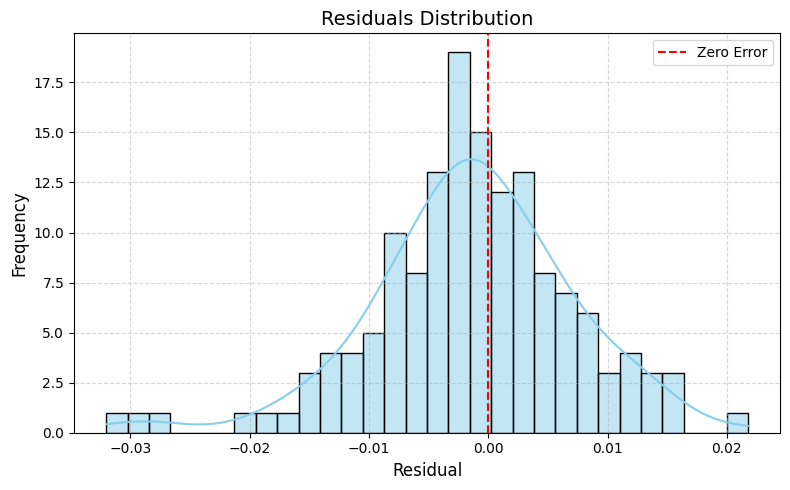

Residuals Summary Statistics:
count    147.000000
mean      -0.001411
std        0.008493
min       -0.032026
25%       -0.006444
50%       -0.001204
75%        0.003583
max        0.021765
Name: CrimeRate, dtype: float64

Distribution Shape:
Skewness : -0.4976 (should be ~0 for symmetric)
Kurtosis : 1.4144 (0 = normal, >0 = heavy tails)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color="skyblue", edgecolor="black")
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.title("Residuals Distribution", fontsize=14)
plt.xlabel("Residual", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Convert residuals to a pandas Series for convenience
residuals_series = pd.Series(residuals)

# Print descriptive statistics
print("Residuals Summary Statistics:")
print(residuals_series.describe())

# Print skewness and kurtosis
print("\nDistribution Shape:")
print(f"Skewness : {skew(residuals):.4f} (should be ~0 for symmetric)")

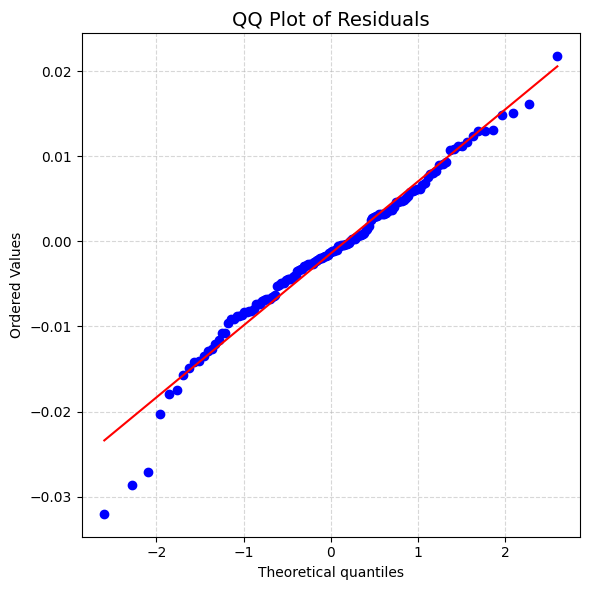

In [ ]:
import scipy.stats as stats

plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

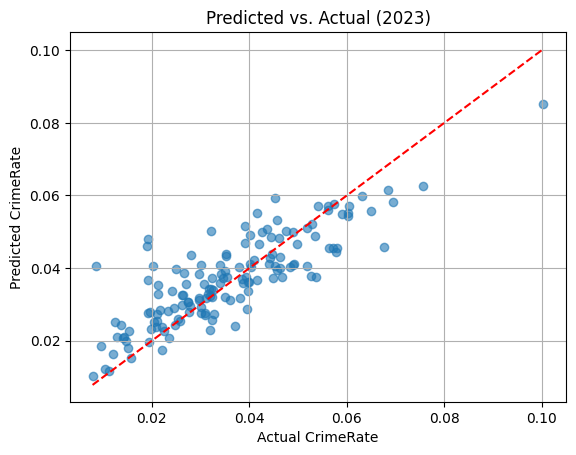

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45-degree line
plt.xlabel("Actual CrimeRate")
plt.ylabel("Predicted CrimeRate")
plt.title("Predicted vs. Actual (2023)")
plt.grid(True)
plt.show()

**Residuals Analysis**

To evaluate the prediction quality and detect any systematic errors, we analyzed the residuals distribution, QQ plot, and predicted vs. actual scatter plot.
- Residual Distribution:
  - Residuals are centered around zero (mean = –0.0014) with low spread (std = 0.008493), indicating minimal bias and tight error margins.
  - Skewness: –0.4976 → Slight left skew, suggesting approximate symmetry.
- QQ Plot: is a graphical tool used to compare the distribution of data (typically residuals) against a theoretical distribution most commonly the normal distribution. It's particularly useful in regression modeling to check if residuals (errors) are approximately normally distributed, which is an assumption in many statistical models.
  - The residuals mostly follow the diagonal line, indicating that errors are approximately normally distributed.
  - Minor deviations at the tails are expected but do not suggest major model issues.
  - Including this diagnostic ensures that the final model's predictions are not only accurate on average but also statistically well-behaved, supporting the reliability of results.
- Predicted vs. Actual Plot:
  - Predictions align closely along the 45° line, showing strong agreement between predicted and actual values.
  - There’s no clear pattern of over- or underestimation, confirming that the model generalizes well.

The residual distribution, QQ plot, and predicted vs. actual scatter plot collectively show that:
- The errors are well-behaved (centered, symmetric, light-tailed).
- The model's predictions are accurate and unbiased.
- No evidence of systematic errors or misspecification was found.

This reinforces the reliability of the CatBoost model in predicting crime rates.

# Feature Importance & SHAP Analysis

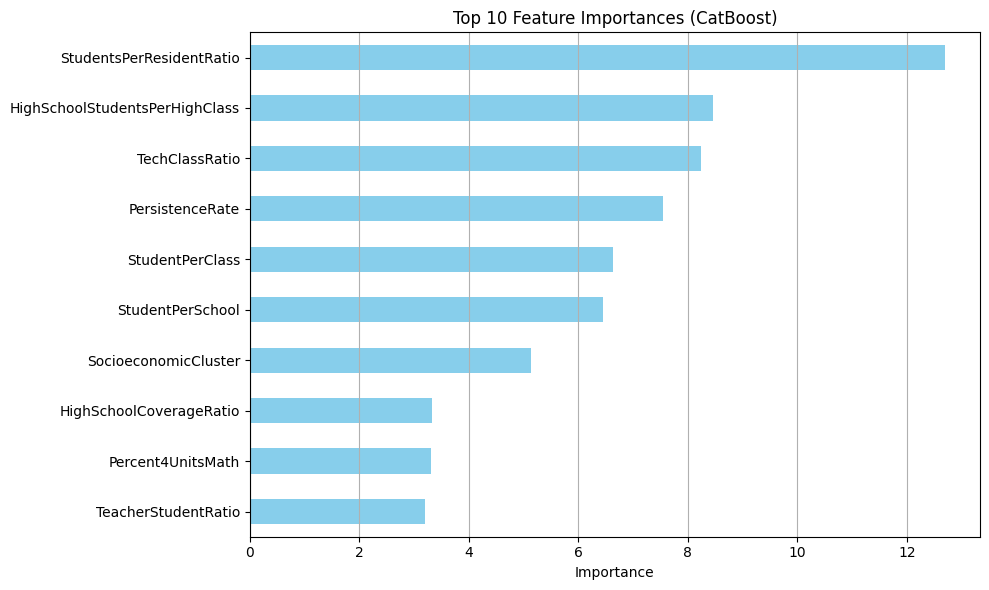


Top 10 Features:
StudentsPerResidentRatio          12.702678
HighSchoolStudentsPerHighClass     8.458200
TechClassRatio                     8.244431
PersistenceRate                    7.549114
StudentPerClass                    6.629422
StudentPerSchool                   6.455886
SocioeconomicCluster               5.133743
HighSchoolCoverageRatio            3.327872
Percent4UnitsMath                  3.302907
TeacherStudentRatio                3.200426
dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
importances = catboost_best.get_feature_importance()
feature_names = X_train.columns

# Create a Series and select top 10
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
top_10_feat = feat_imp.head(10)

# Plot
plt.figure(figsize=(10, 6))
top_10_feat.sort_values().plot(kind="barh", color="skyblue")
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (CatBoost)")
plt.grid(axis="x")
plt.tight_layout()
plt.show()

# Print top 10
print("\nTop 10 Features:")
print(top_10_feat)

**Feature Importance Analysis**

CatBoost provides built-in feature importance values that help identify which variables most influence the model's predictions.

We extracted and visualized the top 10 most impactful features based on their contribution to predicting crime rates.

Top 3 Influential Features:
- StudentsPerResidentRatio – Most impactful feature, suggesting a strong link between student population density and crime.
- HighSchoolStudentsPerHighClass – Indicates the significance of class composition and resource allocation.
- TechClassRatio – Highlights the potential effect of technological education on crime levels.

**SHAP Analysis**

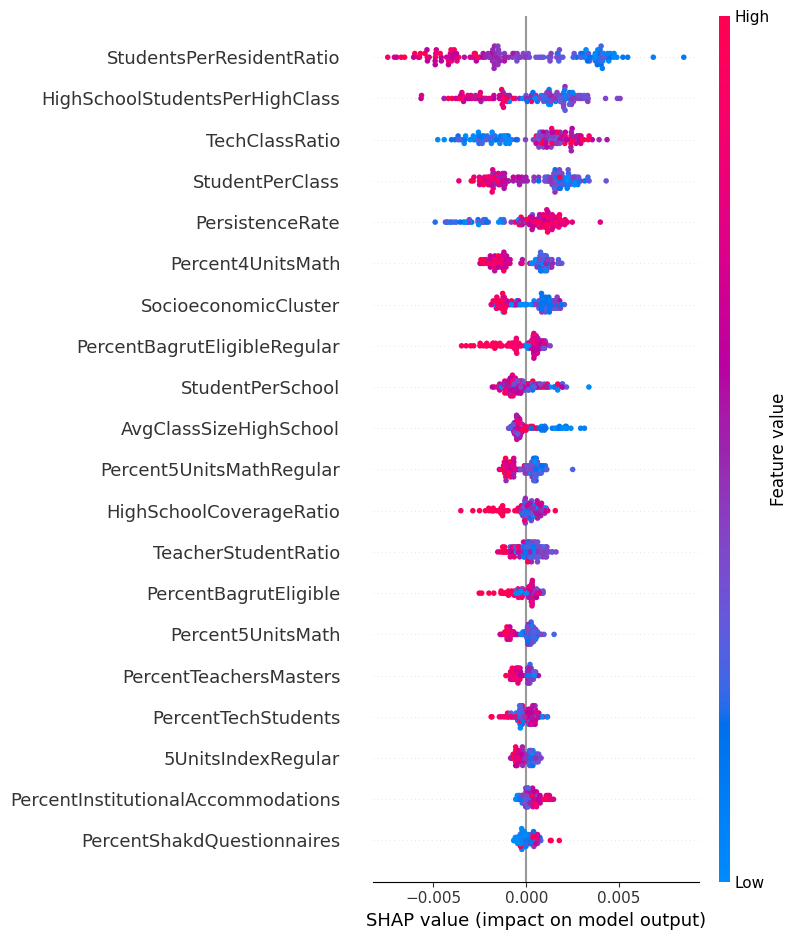

In [ ]:
import shap

# SHAP explainer for CatBoost
explainer = shap.Explainer(catboost_best)
shap_values = explainer(X_test)

# Summary plot (global feature importance + direction)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

**SHAP**

Helps us understand how each feature influences the model’s predictions, the predicted crime rate.
- StudentsPerResidentRatio: Higher values are associated with lower predicted crime rates, while lower values correspond to higher crime rates — indicating a negative relationship. In areas with more students relative to the population, the model predicts lower crime rates. This might reflect a more engaged or structured youth population.
- HighSchoolStudentsPerHighClass: Shows a similar pattern — higher values tend to reduce predicted crime. More high school students per class might suggest higher accessibility, which could correlate with better educational outcomes and lower crime.
- TechClassRatio: Exhibits the opposite effect — higher values are linked to increased crime predictions, which is surprising and may indicate an exception. Unexpectedly, more technological classes relative to other classes are linked with higher predicted crime.
- StudentsPerClass: Also follows the same pattern as StudentsPerResidentRatio, where higher values are associated with reduced crime rates. More students per class may reflect dense, active schooling environments, possibly associated with reduced crime.
- PersistenceRate: Displays a reversed trend — higher values are linked to higher crime predictions, which seems counterintuitive. This represents the proportion of students continuing through school. While we’d expect higher persistence to reduce crime, the model sees the opposite — suggesting a counterintuitive or non-linear relationship.
- SocioeconomicCluster: Again shows the same behavior as the first feature — higher values (indicating better socio-economic status) in this feature usually mean higher socio-economic status, which is often linked to lower crime rates — so this result makes sense.

In [ ]:
!python --version

Python 3.11.12
